In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-1xbnk12d
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-1xbnk12d
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 2703d155c88d27bba9a1f465f5489a7947ffc313
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-1.0.10.dev0-py3-none-any.whl size=2325971 sha256=4153f584110fbd68831966a0dd8d21e27280c46e377ee7a8760d548886f5a10c
  Stored in directory: /tmp/pip-ephem-wheel-cache-5svsi15r/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm
  Attempting uninstall: timm
    Found existing installation: timm 1.0.9
    Uninstalling timm-1.0.9:
      Successfully uninstalled timm-1.0.9


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torch
from tqdm.auto import tqdm
import numpy as np
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [10]:
import seaborn as sns
import cv2
import matplotlib.pyplot as plt 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torchvision import datasets
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

In [11]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
IMAGE_SIZE=(224, 224)
batch_size=8
learning_rate = 5e-4
epochs=20

In [16]:
data_path = '/kaggle/input/brain-tumor-mri-images-44c/'
data = datasets.ImageFolder(data_path,transform=transform)
num_classes = len(data.classes)
classes = data.classes

In [17]:
ds = ImageFolder(data_path, transform = transform)

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, ConcatDataset

labels = [label for _, label in ds]

sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices_1, test_indices = next(sss_train_test.split(torch.zeros(len(labels)), labels))

# Create Subset objects for train and test sets
train_data_1 = Subset(ds, train_indices_1)
test_data = Subset(ds, test_indices)

# Extract labels from the train subset for train-validation split
train_labels_1 = [label for _, label in train_data_1]

# Perform stratified shuffle split for train and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss_train_val.split(torch.zeros(len(train_labels_1)), train_labels_1))

# Create Subset objects for train and validation sets
train_data = Subset(train_data_1, train_indices)
val_data = Subset(train_data_1, val_indices)

In [19]:
BATCH_SIZE = 8
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

train_count=len(glob.glob(data_path+'/**/*.jpg'))
test_count=len(glob.glob(data_path+'/**/*.jpg'))

In [21]:
print(f'The classes are: {classes}')

The classes are: ['Astrocitoma T1', 'Astrocitoma T1C+', 'Astrocitoma T2', 'Carcinoma T1', 'Carcinoma T1C+', 'Carcinoma T2', 'Ependimoma T1', 'Ependimoma T1C+', 'Ependimoma T2', 'Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Germinoma T1C+', 'Germinoma T2', 'Glioblastoma T1', 'Glioblastoma T1C+', 'Glioblastoma T2', 'Granuloma T1', 'Granuloma T1C+', 'Granuloma T2', 'Meduloblastoma T1', 'Meduloblastoma T1C+', 'Meduloblastoma T2', 'Meningioma T1', 'Meningioma T1C+', 'Meningioma T2', 'Neurocitoma T1', 'Neurocitoma T1C+', 'Neurocitoma T2', 'Oligodendroglioma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Papiloma T1', 'Papiloma T1C+', 'Papiloma T2', 'Schwannoma T1', 'Schwannoma T1C+', 'Schwannoma T2', 'Tuberculoma T1', 'Tuberculoma T1C+', 'Tuberculoma T2', '_NORMAL T1', '_NORMAL T2']


In [29]:
num_classes = 44

# Create the model
model = timm.create_model('pit_ti_224', pretrained=True)

# Modify the model's output head
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Move the model to the specified device
model.to(device)

# Print the model summary
summary(model, (3, 224, 224))  #

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 44]                   46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [30]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [31]:
# Define the loss function and optimizer
from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

LR = 0.0005
BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

criterion = torch.nn.CrossEntropyLoss() 
# criterion_DRW = torch.nn.CrossEntropyLoss(weight = weight)


In [32]:
total_epochs = 40

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
#     scheduler.step()

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/40]: 100%|██████████| 359/359 [00:32<00:00, 11.18it/s]


Metrics - loss: 3.5585, accuracy: 0.0750, precision: 0.0331, recall: 0.0750, f1_score: 0.0408, specificity: 0.0088, sensitivity: 0.9807, mcc: 0.0111, auc: 0.5087


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.49it/s]


Metrics - loss: 3.4435, accuracy: 0.0823, precision: 0.0099, recall: 0.0823, f1_score: 0.0176, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0312, auc: 0.6114


Training Model - Epoch [2/40]: 100%|██████████| 359/359 [00:32<00:00, 10.91it/s]


Metrics - loss: 3.4252, accuracy: 0.0956, precision: 0.0458, recall: 0.0956, f1_score: 0.0548, specificity: 0.0088, sensitivity: 0.9916, mcc: 0.0375, auc: 0.5992


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 16.84it/s]


Metrics - loss: 3.3501, accuracy: 0.1074, precision: 0.0328, recall: 0.1074, f1_score: 0.0361, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0626, auc: 0.6619


Training Model - Epoch [3/40]: 100%|██████████| 359/359 [00:31<00:00, 11.49it/s]


Metrics - loss: 3.2946, accuracy: 0.1301, precision: 0.0731, recall: 0.1301, f1_score: 0.0813, specificity: 0.0354, sensitivity: 0.9753, mcc: 0.0779, auc: 0.6603


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.74it/s]


Metrics - loss: 3.2384, accuracy: 0.1269, precision: 0.0560, recall: 0.1269, f1_score: 0.0669, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.0823, auc: 0.7062


Training Model - Epoch [4/40]: 100%|██████████| 359/359 [00:31<00:00, 11.40it/s]


Metrics - loss: 3.1609, accuracy: 0.1588, precision: 0.1054, recall: 0.1588, f1_score: 0.1116, specificity: 0.0708, sensitivity: 0.9815, mcc: 0.1112, auc: 0.7158


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.72it/s]


Metrics - loss: 3.0906, accuracy: 0.1618, precision: 0.0923, recall: 0.1618, f1_score: 0.1021, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1236, auc: 0.7435


Training Model - Epoch [5/40]: 100%|██████████| 359/359 [00:31<00:00, 11.50it/s]


Metrics - loss: 3.0455, accuracy: 0.1759, precision: 0.1225, recall: 0.1759, f1_score: 0.1334, specificity: 0.0531, sensitivity: 0.9775, mcc: 0.1303, auc: 0.7551


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.00it/s]


Metrics - loss: 3.0019, accuracy: 0.1799, precision: 0.1235, recall: 0.1799, f1_score: 0.1286, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1390, auc: 0.7667


Training Model - Epoch [6/40]: 100%|██████████| 359/359 [00:31<00:00, 11.44it/s]


Metrics - loss: 2.9249, accuracy: 0.2045, precision: 0.1705, recall: 0.2045, f1_score: 0.1697, specificity: 0.0796, sensitivity: 0.9840, mcc: 0.1624, auc: 0.7868


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.44it/s]


Metrics - loss: 2.7952, accuracy: 0.2190, precision: 0.1573, recall: 0.2190, f1_score: 0.1632, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.1879, auc: 0.8217


Training Model - Epoch [7/40]: 100%|██████████| 359/359 [00:31<00:00, 11.28it/s]


Metrics - loss: 2.6409, accuracy: 0.2725, precision: 0.2530, recall: 0.2725, f1_score: 0.2430, specificity: 0.1327, sensitivity: 0.9818, mcc: 0.2367, auc: 0.8376


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.68it/s]


Metrics - loss: 2.5545, accuracy: 0.2748, precision: 0.2342, recall: 0.2748, f1_score: 0.2257, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.2469, auc: 0.8563


Training Model - Epoch [8/40]: 100%|██████████| 359/359 [00:31<00:00, 11.52it/s]


Metrics - loss: 2.3076, accuracy: 0.3500, precision: 0.3205, recall: 0.3500, f1_score: 0.3208, specificity: 0.1150, sensitivity: 0.9807, mcc: 0.3196, auc: 0.8892


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.26it/s]


Metrics - loss: 2.1940, accuracy: 0.3947, precision: 0.3543, recall: 0.3947, f1_score: 0.3511, specificity: 0.0000, sensitivity: 0.9942, mcc: 0.3680, auc: 0.9030


Training Model - Epoch [9/40]: 100%|██████████| 359/359 [00:30<00:00, 11.61it/s]


Metrics - loss: 2.0835, accuracy: 0.4061, precision: 0.3877, recall: 0.4061, f1_score: 0.3855, specificity: 0.2566, sensitivity: 0.9753, mcc: 0.3790, auc: 0.9113


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.54it/s]


Metrics - loss: 1.9529, accuracy: 0.4351, precision: 0.4348, recall: 0.4351, f1_score: 0.3993, specificity: 0.0357, sensitivity: 0.9985, mcc: 0.4113, auc: 0.9187


Training Model - Epoch [10/40]: 100%|██████████| 359/359 [00:31<00:00, 11.55it/s]


Metrics - loss: 1.8097, accuracy: 0.4724, precision: 0.4628, recall: 0.4724, f1_score: 0.4599, specificity: 0.2389, sensitivity: 0.9746, mcc: 0.4495, auc: 0.9381


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.00it/s]


Metrics - loss: 1.7520, accuracy: 0.4965, precision: 0.4751, recall: 0.4965, f1_score: 0.4605, specificity: 0.0357, sensitivity: 0.9898, mcc: 0.4753, auc: 0.9376


Training Model - Epoch [11/40]: 100%|██████████| 359/359 [00:30<00:00, 11.67it/s]


Metrics - loss: 1.6023, accuracy: 0.5157, precision: 0.5106, recall: 0.5157, f1_score: 0.5069, specificity: 0.3009, sensitivity: 0.9746, mcc: 0.4948, auc: 0.9553


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.69it/s]


Metrics - loss: 1.6581, accuracy: 0.5300, precision: 0.5110, recall: 0.5300, f1_score: 0.4917, specificity: 0.0357, sensitivity: 0.9956, mcc: 0.5104, auc: 0.9397


Training Model - Epoch [12/40]: 100%|██████████| 359/359 [00:31<00:00, 11.28it/s]


Metrics - loss: 1.3883, accuracy: 0.5886, precision: 0.5768, recall: 0.5886, f1_score: 0.5771, specificity: 0.3451, sensitivity: 0.9815, mcc: 0.5712, auc: 0.9655


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.29it/s]


Metrics - loss: 1.5347, accuracy: 0.5900, precision: 0.5962, recall: 0.5900, f1_score: 0.5674, specificity: 0.2857, sensitivity: 0.9724, mcc: 0.5737, auc: 0.9474


Training Model - Epoch [13/40]: 100%|██████████| 359/359 [00:31<00:00, 11.28it/s]


Metrics - loss: 1.2137, accuracy: 0.6232, precision: 0.6215, recall: 0.6232, f1_score: 0.6180, specificity: 0.3982, sensitivity: 0.9786, mcc: 0.6073, auc: 0.9756


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.98it/s]


Metrics - loss: 1.5862, accuracy: 0.5579, precision: 0.5891, recall: 0.5579, f1_score: 0.5357, specificity: 0.1071, sensitivity: 0.9913, mcc: 0.5427, auc: 0.9447


Training Model - Epoch [14/40]: 100%|██████████| 359/359 [00:31<00:00, 11.38it/s]


Metrics - loss: 0.9932, accuracy: 0.6891, precision: 0.6862, recall: 0.6891, f1_score: 0.6858, specificity: 0.4956, sensitivity: 0.9851, mcc: 0.6764, auc: 0.9836


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.36it/s]


Metrics - loss: 1.4312, accuracy: 0.5704, precision: 0.6002, recall: 0.5704, f1_score: 0.5591, specificity: 0.2143, sensitivity: 0.9898, mcc: 0.5541, auc: 0.9555


Training Model - Epoch [15/40]: 100%|██████████| 359/359 [00:30<00:00, 11.61it/s]


Metrics - loss: 0.8994, accuracy: 0.7167, precision: 0.7159, recall: 0.7167, f1_score: 0.7147, specificity: 0.5487, sensitivity: 0.9833, mcc: 0.7050, auc: 0.9874


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 16.80it/s]


Metrics - loss: 1.2643, accuracy: 0.6485, precision: 0.6760, recall: 0.6485, f1_score: 0.6320, specificity: 0.1786, sensitivity: 0.9927, mcc: 0.6364, auc: 0.9658


Training Model - Epoch [16/40]: 100%|██████████| 359/359 [00:31<00:00, 11.48it/s]


Metrics - loss: 0.7405, accuracy: 0.7624, precision: 0.7614, recall: 0.7624, f1_score: 0.7608, specificity: 0.6372, sensitivity: 0.9869, mcc: 0.7527, auc: 0.9918


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 19.13it/s]


Metrics - loss: 1.2114, accuracy: 0.6792, precision: 0.7020, recall: 0.6792, f1_score: 0.6638, specificity: 0.2143, sensitivity: 0.9942, mcc: 0.6680, auc: 0.9688


Training Model - Epoch [17/40]: 100%|██████████| 359/359 [00:31<00:00, 11.52it/s]


Metrics - loss: 0.5938, accuracy: 0.8095, precision: 0.8097, recall: 0.8095, f1_score: 0.8088, specificity: 0.6726, sensitivity: 0.9880, mcc: 0.8018, auc: 0.9947


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.44it/s]


Metrics - loss: 1.2627, accuracy: 0.6597, precision: 0.6929, recall: 0.6597, f1_score: 0.6487, specificity: 0.2857, sensitivity: 0.9956, mcc: 0.6478, auc: 0.9627


Training Model - Epoch [18/40]: 100%|██████████| 359/359 [00:31<00:00, 11.55it/s]


Metrics - loss: 0.6801, accuracy: 0.7812, precision: 0.7823, recall: 0.7812, f1_score: 0.7805, specificity: 0.5841, sensitivity: 0.9858, mcc: 0.7724, auc: 0.9926


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.37it/s]


Metrics - loss: 1.1424, accuracy: 0.6960, precision: 0.7224, recall: 0.6960, f1_score: 0.6920, specificity: 0.3571, sensitivity: 0.9913, mcc: 0.6846, auc: 0.9705


Training Model - Epoch [19/40]: 100%|██████████| 359/359 [00:31<00:00, 11.48it/s]


Metrics - loss: 0.5666, accuracy: 0.8193, precision: 0.8200, recall: 0.8193, f1_score: 0.8190, specificity: 0.6903, sensitivity: 0.9887, mcc: 0.8120, auc: 0.9953


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.35it/s]


Metrics - loss: 1.0688, accuracy: 0.7350, precision: 0.7596, recall: 0.7350, f1_score: 0.7322, specificity: 0.7143, sensitivity: 0.9869, mcc: 0.7251, auc: 0.9700


Training Model - Epoch [20/40]: 100%|██████████| 359/359 [00:31<00:00, 11.54it/s]


Metrics - loss: 0.5306, accuracy: 0.8280, precision: 0.8280, recall: 0.8280, f1_score: 0.8275, specificity: 0.6991, sensitivity: 0.9887, mcc: 0.8210, auc: 0.9957


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.29it/s]


Metrics - loss: 1.1403, accuracy: 0.6987, precision: 0.7273, recall: 0.6987, f1_score: 0.6947, specificity: 0.4643, sensitivity: 0.9826, mcc: 0.6882, auc: 0.9713


Training Model - Epoch [21/40]: 100%|██████████| 359/359 [00:30<00:00, 11.68it/s]


Metrics - loss: 0.4066, accuracy: 0.8618, precision: 0.8616, recall: 0.8618, f1_score: 0.8612, specificity: 0.7434, sensitivity: 0.9895, mcc: 0.8563, auc: 0.9975


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.42it/s]


Metrics - loss: 1.0892, accuracy: 0.7183, precision: 0.7321, recall: 0.7183, f1_score: 0.7092, specificity: 0.6071, sensitivity: 0.9869, mcc: 0.7076, auc: 0.9676


Training Model - Epoch [22/40]: 100%|██████████| 359/359 [00:31<00:00, 11.50it/s]


Metrics - loss: 0.3944, accuracy: 0.8685, precision: 0.8689, recall: 0.8685, f1_score: 0.8680, specificity: 0.7788, sensitivity: 0.9920, mcc: 0.8632, auc: 0.9977


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.04it/s]


Metrics - loss: 0.9343, accuracy: 0.7657, precision: 0.7826, recall: 0.7657, f1_score: 0.7644, specificity: 0.7143, sensitivity: 0.9913, mcc: 0.7569, auc: 0.9803


Training Model - Epoch [23/40]: 100%|██████████| 359/359 [00:31<00:00, 11.41it/s]


Metrics - loss: 0.3723, accuracy: 0.8768, precision: 0.8768, recall: 0.8768, f1_score: 0.8763, specificity: 0.8142, sensitivity: 0.9949, mcc: 0.8719, auc: 0.9979


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 19.15it/s]


Metrics - loss: 0.9368, accuracy: 0.7796, precision: 0.8002, recall: 0.7796, f1_score: 0.7785, specificity: 0.6786, sensitivity: 0.9898, mcc: 0.7711, auc: 0.9800


Training Model - Epoch [24/40]: 100%|██████████| 359/359 [00:31<00:00, 11.40it/s]


Metrics - loss: 0.4802, accuracy: 0.8430, precision: 0.8434, recall: 0.8430, f1_score: 0.8426, specificity: 0.7788, sensitivity: 0.9909, mcc: 0.8367, auc: 0.9968


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.91it/s]


Metrics - loss: 0.9872, accuracy: 0.7573, precision: 0.7902, recall: 0.7573, f1_score: 0.7485, specificity: 0.5714, sensitivity: 0.9942, mcc: 0.7485, auc: 0.9716


Training Model - Epoch [25/40]: 100%|██████████| 359/359 [00:31<00:00, 11.46it/s]


Metrics - loss: 0.2882, accuracy: 0.9058, precision: 0.9063, recall: 0.9058, f1_score: 0.9057, specificity: 0.7699, sensitivity: 0.9916, mcc: 0.9020, auc: 0.9987


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.63it/s]


Metrics - loss: 1.0152, accuracy: 0.7350, precision: 0.7521, recall: 0.7350, f1_score: 0.7331, specificity: 0.7143, sensitivity: 0.9826, mcc: 0.7254, auc: 0.9804


Training Model - Epoch [26/40]: 100%|██████████| 359/359 [00:31<00:00, 11.55it/s]


Metrics - loss: 0.2033, accuracy: 0.9316, precision: 0.9321, recall: 0.9316, f1_score: 0.9316, specificity: 0.8761, sensitivity: 0.9927, mcc: 0.9289, auc: 0.9993


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.63it/s]


Metrics - loss: 1.0500, accuracy: 0.7211, precision: 0.7672, recall: 0.7211, f1_score: 0.7262, specificity: 0.8214, sensitivity: 0.9826, mcc: 0.7113, auc: 0.9813


Training Model - Epoch [27/40]: 100%|██████████| 359/359 [00:30<00:00, 11.59it/s]


Metrics - loss: 0.3827, accuracy: 0.8786, precision: 0.8793, recall: 0.8786, f1_score: 0.8786, specificity: 0.8230, sensitivity: 0.9916, mcc: 0.8737, auc: 0.9976


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.83it/s]


Metrics - loss: 1.1362, accuracy: 0.7350, precision: 0.7600, recall: 0.7350, f1_score: 0.7311, specificity: 0.5357, sensitivity: 0.9826, mcc: 0.7250, auc: 0.9732


Training Model - Epoch [28/40]: 100%|██████████| 359/359 [00:30<00:00, 11.77it/s]


Metrics - loss: 0.2895, accuracy: 0.9068, precision: 0.9072, recall: 0.9068, f1_score: 0.9068, specificity: 0.8938, sensitivity: 0.9946, mcc: 0.9031, auc: 0.9986


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 19.35it/s]


Metrics - loss: 0.9798, accuracy: 0.7629, precision: 0.7770, recall: 0.7629, f1_score: 0.7616, specificity: 0.6786, sensitivity: 0.9913, mcc: 0.7541, auc: 0.9760


Training Model - Epoch [29/40]: 100%|██████████| 359/359 [00:31<00:00, 11.55it/s]


Metrics - loss: 0.3010, accuracy: 0.9065, precision: 0.9073, recall: 0.9065, f1_score: 0.9066, specificity: 0.8496, sensitivity: 0.9935, mcc: 0.9027, auc: 0.9986


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.36it/s]


Metrics - loss: 1.0189, accuracy: 0.7545, precision: 0.7753, recall: 0.7545, f1_score: 0.7519, specificity: 0.4643, sensitivity: 0.9956, mcc: 0.7451, auc: 0.9746


Training Model - Epoch [30/40]: 100%|██████████| 359/359 [00:31<00:00, 11.33it/s]


Metrics - loss: 0.2177, accuracy: 0.9320, precision: 0.9323, recall: 0.9320, f1_score: 0.9319, specificity: 0.8938, sensitivity: 0.9949, mcc: 0.9292, auc: 0.9992


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.91it/s]


Metrics - loss: 0.9227, accuracy: 0.7964, precision: 0.8185, recall: 0.7964, f1_score: 0.7907, specificity: 0.8214, sensitivity: 0.9724, mcc: 0.7889, auc: 0.9817


Training Model - Epoch [31/40]: 100%|██████████| 359/359 [00:31<00:00, 11.53it/s]


Metrics - loss: 0.2311, accuracy: 0.9257, precision: 0.9257, recall: 0.9257, f1_score: 0.9255, specificity: 0.8850, sensitivity: 0.9949, mcc: 0.9227, auc: 0.9990


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.85it/s]


Metrics - loss: 0.9545, accuracy: 0.7768, precision: 0.7996, recall: 0.7768, f1_score: 0.7701, specificity: 0.6071, sensitivity: 0.9927, mcc: 0.7687, auc: 0.9788


Training Model - Epoch [32/40]: 100%|██████████| 359/359 [00:31<00:00, 11.47it/s]


Metrics - loss: 0.3506, accuracy: 0.8870, precision: 0.8875, recall: 0.8870, f1_score: 0.8869, specificity: 0.8319, sensitivity: 0.9931, mcc: 0.8824, auc: 0.9978


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.70it/s]


Metrics - loss: 1.1199, accuracy: 0.7350, precision: 0.7607, recall: 0.7350, f1_score: 0.7282, specificity: 0.7143, sensitivity: 0.9942, mcc: 0.7251, auc: 0.9748


Training Model - Epoch [33/40]: 100%|██████████| 359/359 [00:31<00:00, 11.57it/s]


Metrics - loss: 0.2454, accuracy: 0.9218, precision: 0.9220, recall: 0.9218, f1_score: 0.9217, specificity: 0.8938, sensitivity: 0.9964, mcc: 0.9187, auc: 0.9989


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.09it/s]


Metrics - loss: 1.0457, accuracy: 0.7559, precision: 0.7841, recall: 0.7559, f1_score: 0.7493, specificity: 0.7500, sensitivity: 0.9913, mcc: 0.7469, auc: 0.9837


Training Model - Epoch [34/40]: 100%|██████████| 359/359 [00:31<00:00, 11.31it/s]


Metrics - loss: 0.1947, accuracy: 0.9396, precision: 0.9399, recall: 0.9396, f1_score: 0.9396, specificity: 0.9381, sensitivity: 0.9964, mcc: 0.9372, auc: 0.9993


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.26it/s]


Metrics - loss: 0.8546, accuracy: 0.8047, precision: 0.8242, recall: 0.8047, f1_score: 0.8029, specificity: 0.6429, sensitivity: 0.9956, mcc: 0.7976, auc: 0.9838


Training Model - Epoch [35/40]: 100%|██████████| 359/359 [00:31<00:00, 11.43it/s]


Metrics - loss: 0.1730, accuracy: 0.9435, precision: 0.9437, recall: 0.9435, f1_score: 0.9434, specificity: 0.8850, sensitivity: 0.9953, mcc: 0.9412, auc: 0.9995


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.40it/s]


Metrics - loss: 0.9521, accuracy: 0.8020, precision: 0.8203, recall: 0.8020, f1_score: 0.7970, specificity: 0.5714, sensitivity: 0.9956, mcc: 0.7942, auc: 0.9822


Training Model - Epoch [36/40]: 100%|██████████| 359/359 [00:30<00:00, 11.66it/s]


Metrics - loss: 0.2379, accuracy: 0.9218, precision: 0.9221, recall: 0.9218, f1_score: 0.9216, specificity: 0.8584, sensitivity: 0.9942, mcc: 0.9187, auc: 0.9990


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.56it/s]


Metrics - loss: 0.8810, accuracy: 0.8243, precision: 0.8452, recall: 0.8243, f1_score: 0.8243, specificity: 0.5000, sensitivity: 0.9927, mcc: 0.8179, auc: 0.9837


Training Model - Epoch [37/40]: 100%|██████████| 359/359 [00:31<00:00, 11.44it/s]


Metrics - loss: 0.1734, accuracy: 0.9452, precision: 0.9456, recall: 0.9452, f1_score: 0.9452, specificity: 0.8673, sensitivity: 0.9960, mcc: 0.9430, auc: 0.9994


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.75it/s]


Metrics - loss: 1.0426, accuracy: 0.7852, precision: 0.8172, recall: 0.7852, f1_score: 0.7841, specificity: 0.8214, sensitivity: 0.9884, mcc: 0.7777, auc: 0.9789


Training Model - Epoch [38/40]: 100%|██████████| 359/359 [00:32<00:00, 11.15it/s]


Metrics - loss: 0.2084, accuracy: 0.9351, precision: 0.9356, recall: 0.9351, f1_score: 0.9350, specificity: 0.9469, sensitivity: 0.9960, mcc: 0.9325, auc: 0.9991


Validating Model: 100%|██████████| 90/90 [00:05<00:00, 17.57it/s]


Metrics - loss: 0.9597, accuracy: 0.7964, precision: 0.8168, recall: 0.7964, f1_score: 0.7938, specificity: 0.6786, sensitivity: 0.9971, mcc: 0.7891, auc: 0.9808


Training Model - Epoch [39/40]: 100%|██████████| 359/359 [00:31<00:00, 11.48it/s]


Metrics - loss: 0.2698, accuracy: 0.9138, precision: 0.9138, recall: 0.9138, f1_score: 0.9137, specificity: 0.8319, sensitivity: 0.9953, mcc: 0.9104, auc: 0.9988


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.78it/s]


Metrics - loss: 0.9251, accuracy: 0.7964, precision: 0.8211, recall: 0.7964, f1_score: 0.7977, specificity: 0.6786, sensitivity: 0.9884, mcc: 0.7890, auc: 0.9779


Training Model - Epoch [40/40]: 100%|██████████| 359/359 [00:31<00:00, 11.53it/s]


Metrics - loss: 0.1556, accuracy: 0.9498, precision: 0.9499, recall: 0.9498, f1_score: 0.9497, specificity: 0.8938, sensitivity: 0.9953, mcc: 0.9478, auc: 0.9995


Validating Model: 100%|██████████| 90/90 [00:04<00:00, 18.51it/s]

Metrics - loss: 0.9391, accuracy: 0.8075, precision: 0.8221, recall: 0.8075, f1_score: 0.8044, specificity: 0.6786, sensitivity: 0.9942, mcc: 0.8003, auc: 0.9777
Total Training Time: 0:20:53.298929
Total Validation Time: 0:03:18.480677
Average Training Time per Epoch: 0:00:31.332473
Average Validation Time per Epoch: 0:00:04.962017


In [33]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 112/112 [00:07<00:00, 15.02it/s]


Metrics - loss: 0.8069, accuracy: 0.8125, precision: 0.8243, recall: 0.8125, f1_score: 0.8121, specificity: 0.7714, sensitivity: 0.9965, mcc: 0.8055, auc: 0.9789


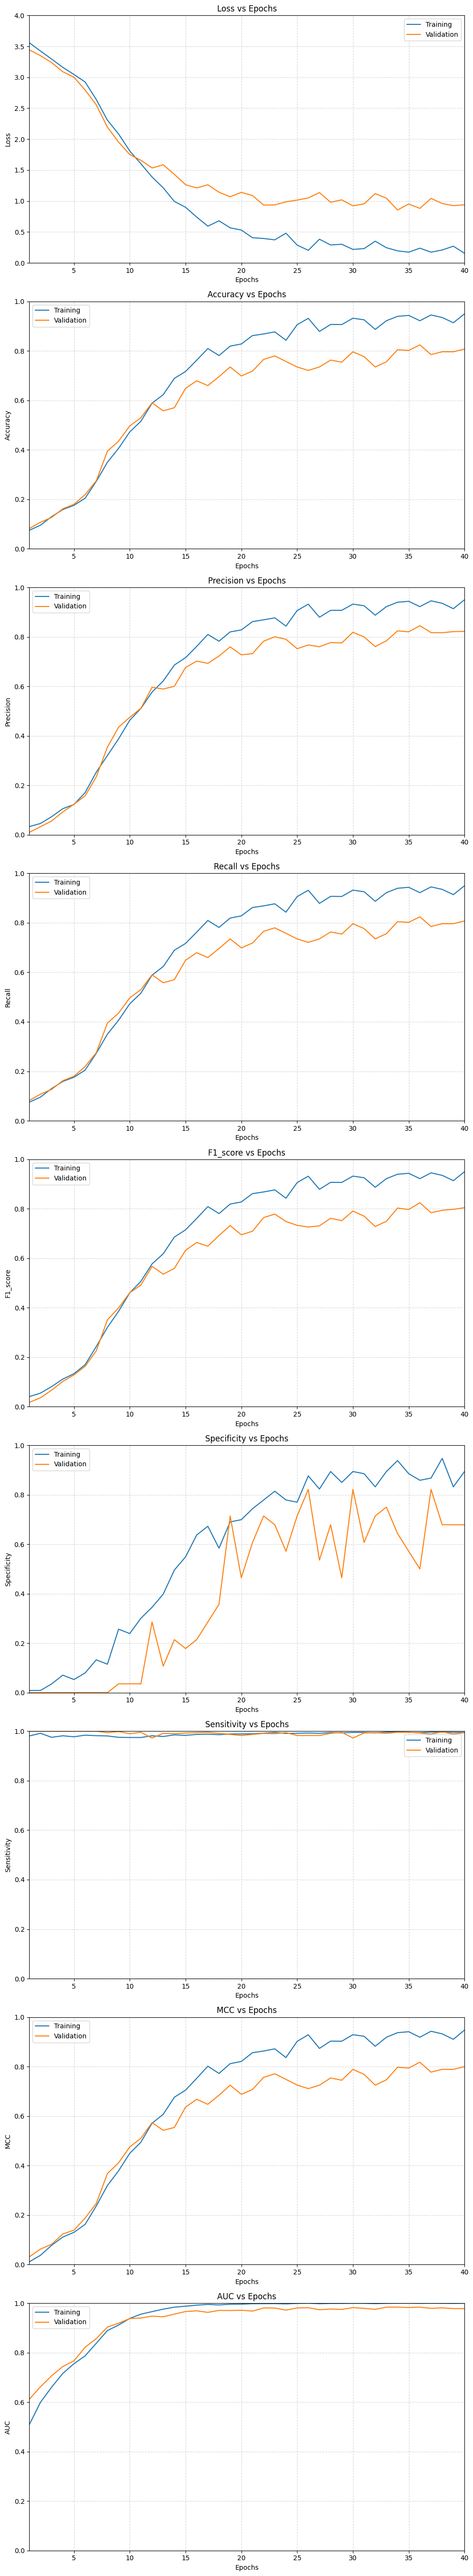

In [34]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

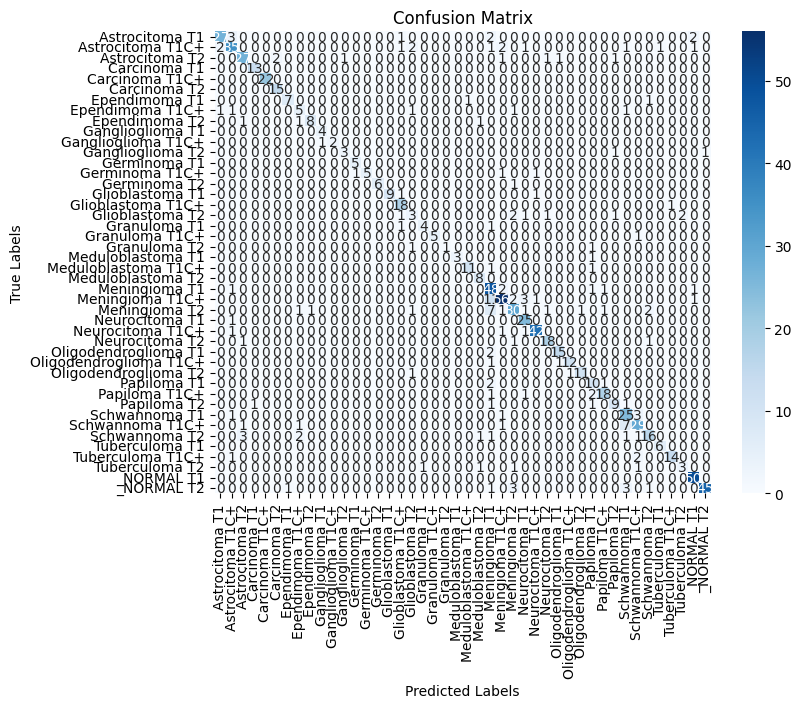

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have test_labels (targets) and test_predictions (predicted labels)
# Convert the softmax/logit outputs to predicted labels by taking the argmax
# if your output is a softmax over classes
predicted_labels = np.argmax(all_predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, predicted_labels)

# Plot confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
